In [6]:
from ngboost import NGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
from datetime import datetime as dt
import numpy as np
from epftoolbox.data import read_data
from epftoolbox.evaluation import MAE, sMAPE
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv('df_train.csv', parse_dates=['Date'])
test_data = pd.read_csv('df_test_pjm30.csv', parse_dates=['Date'])
#test_data1 = pd.read_csv('df_test_f.csv', parse_dates=['Date'])
train_data

,Date,Price,Exogenous 1,Exogenous 2
0,2013-01-01 00:00:00,25.464211,85049.0,11509.0
1,2013-01-01 01:00:00,23.554578,82128.0,10942.0
2,2013-01-01 02:00:00,22.122277,80729.0,10639.0
3,2013-01-01 03:00:00,21.592066,80248.0,10476.0
4,2013-01-01 04:00:00,21.546501,80850.0,10445.0
...,...,...,...,...
43675,2017-12-25 19:00:00,29.139880,93969.0,11695.0
43676,2017-12-25 20:00:00,29.304909,93665.0,11651.0
43677,2017-12-25 21:00:00,29.332579,92507.0,11568.0
43678,2017-12-25 22:00:00,26.418619,90151.0,11371.0


In [3]:
test_data

,Date,Price,Exogenous 1,Exogenous 2
0,2017-12-26 00:00:00,24.646285,90446,10913
1,2017-12-26 01:00:00,24.068853,89027,10638
2,2017-12-26 02:00:00,23.743595,88770,10536
3,2017-12-26 03:00:00,23.805491,89464,10525
4,2017-12-26 04:00:00,24.446306,91850,10580
...,...,...,...,...
739,2018-01-25 19:00:00,37.847949,108321,12810
740,2018-01-25 20:00:00,36.477860,107637,12666
741,2018-01-25 21:00:00,33.955580,104724,12425
742,2018-01-25 22:00:00,26.045406,99899,11959


In [4]:
# Defining empty forecast array and the real values to be predicted in a more friendly format
forecast = pd.DataFrame(index=test_data.index[::24], columns=['h' + str(k) for k in range(24)])
real_values = test_data.loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [7]:
train_data['day'] = train_data['Date'].apply(lambda x: x.day)
train_data['month'] = train_data['Date'].apply(lambda x: x.month)
train_data['year'] = train_data['Date'].apply(lambda x: x.year)
train_data['hour'] = train_data['Date'].apply(lambda x: x.hour)
#train_data['minute'] = train_data['Date'].apply(lambda x: x.day)

train_data['day_of_year'] = train_data['Date'].apply(lambda x: x.day_of_year)
train_data['week_day'] = train_data['Date'].apply(lambda x: x.weekday())
train_data['week_of_year'] = train_data['Date'].apply(lambda x: x.week)

test_data['day'] = test_data['Date'].apply(lambda x: x.day)
test_data['month'] = test_data['Date'].apply(lambda x: x.month)
test_data['year'] = test_data['Date'].apply(lambda x: x.year)
test_data['hour'] = test_data['Date'].apply(lambda x: x.hour)
#test_data['minute'] = test_data['Date'].apply(lambda x: x.day)

test_data['day_of_year'] = test_data['Date'].apply(lambda x: x.day_of_year)
test_data['week_day'] = test_data['Date'].apply(lambda x: x.weekday())
test_data['week_of_year'] = test_data['Date'].apply(lambda x: x.week)

#converting the date into ng boost acceptable format

In [8]:
train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)

In [9]:
cols=['h0_m','h0_sd','h1_m','h1_sd','h2_m','h2_sd','h3_m','h3_sd','h4_m','h4_sd','h5_m','h5_sd','h6_m','h6_sd',
        'h7_m','h7_sd','h8_m','h8_sd','h9_m','h9_sd','h10_m','h10_sd','h11_m','h11_sd','h12_m','h12_sd','h13_m','h13_sd',
        'h14_m','h14_sd','h15_m','h15_sd','h16_m','h16_sd','h17_m','h17_sd','h18_m','h18_sd','h19_m','h19_sd',
         'h20_m','h20_sd','h21_m','h21_sd','h22_m','h22_sd','h23_m','h23_sd']

forecast_ng = pd.DataFrame(index=test_data.index[::24], columns=cols)

#forecast_ng = pd.DataFrame(index=test_data.index[::24], columns=['m_h' + str(k) for k in range()])



# frame for h0, h1, h2... h24
real_values_ng = test_data.loc[:, ['Price']].values.reshape(-1, 24)
# to the location
real_values_ng = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)
#inserting the forecasted values into the dataframe

In [10]:
real_values_ng.index = forecast_ng.index

In [11]:
forecast_dates_ng = forecast_ng.index

In [12]:
real_values.head()

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-26,24.646285,24.068853,23.743595,23.805491,24.446306,26.521097,33.461651,39.227186,34.829792,34.622832,...,27.907661,27.642022,30.747208,42.699325,40.596959,39.784457,38.748397,36.375769,30.411401,27.141069
2017-12-27,30.674211,28.433706,27.731463,27.330482,27.560174,28.824880,35.354161,46.501133,50.825768,49.037583,...,33.434649,33.298900,34.920730,47.712037,54.505820,53.695492,48.896679,39.949268,41.445581,34.502144
2017-12-28,42.599881,34.323384,31.287477,30.427666,30.069380,32.572875,34.881446,53.265360,67.990967,78.431297,...,38.927855,40.246629,44.455454,59.026617,81.404669,81.886580,62.667075,55.010872,49.193123,37.611028
2017-12-29,58.071407,39.477653,33.097188,30.400220,28.551435,33.339406,56.213605,71.588944,80.646195,79.440314,...,47.126060,46.140448,53.618948,67.650666,80.203513,74.773218,70.120095,63.484027,59.393502,44.754876
2017-12-30,33.167062,28.276439,26.468788,24.776712,24.463093,24.780761,25.657920,26.405114,28.936465,29.779463,...,26.871044,27.127493,29.188952,44.212029,55.751407,49.977793,45.840350,41.682935,40.280407,35.783622


In [13]:
X_train = train_data.drop('Price', axis=1)
y_train = train_data['Price']

X_test = test_data.drop('Price', axis=1)
y_test = test_data['Price']


In [14]:
#loop over each date:


for date in forecast_dates_ng:
    
    print(date)

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([train_data, test_data.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    #Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
    #                                             calibration_window=365)
    
    X_train = data_available.loc[train_data.index.values].drop('Price', axis=1)
    y_train = data_available.loc[train_data.index.values]['Price']
    
    X_test = data_available.loc[date:date + pd.Timedelta(hours=23)].drop('Price', axis=1)
    y_test = data_available.loc[date:date + pd.Timedelta(hours=23), 'Price']
    
    #print(y_test)

    print("training ngboost")
    ngb = NGBRegressor()#learning_rate=0.09, n_estimators=800)
    ngb.fit(X_train, y_train)
    print("ngboost trained")
    
    ## train the NgBoost model
    ## make a prediction for the 24 hours over the "date"
    ## model.fit(X_train, y_train)
    
    #get out t he predicted price at each hour in the "date"
    
    y0_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[0]).T)
    y1_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[1]).T)
    y2_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[2]).T)
    y3_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[3]).T)
    y4_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[4]).T)
    y5_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[5]).T)
    y6_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[6]).T)
    y7_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[7]).T)
    y8_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[8]).T)
    y9_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[9]).T)
    y10_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[10]).T)
    y11_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[11]).T)
    y12_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[12]).T)
    y13_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[13]).T)
    y14_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[14]).T)
    y15_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[15]).T)
    y16_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[16]).T)
    y17_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[17]).T)
    y18_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[18]).T)
    y19_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[19]).T)
    y20_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[20]).T)
    y21_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[21]).T)
    y22_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[22]).T)
    y23_dist = ngb.pred_dist(pd.DataFrame(X_test.iloc[23]).T)
    
    print("y0_dist")
    y0_mean = y0_dist.loc[0]
    y0_sd = y0_dist.scale[0]
    print(y0_mean,y0_sd)
    
    y1_mean = y1_dist.loc[0]
    y1_sd = y1_dist.scale[0]
    print(y1_mean,y1_sd)
    
    y2_mean = y2_dist.loc[0]
    y2_sd = y2_dist.scale[0]
    print(y2_mean,y2_sd)
    
    y3_mean = y3_dist.loc[0]
    y3_sd = y3_dist.scale[0]
    print(y3_mean,y3_sd)
    
    y4_mean = y4_dist.loc[0]
    y4_sd = y4_dist.scale[0]
    print(y4_mean,y4_sd)
   
    y5_mean = y5_dist.loc[0]
    y5_sd = y5_dist.scale[0]
    print(y5_mean,y5_sd)
    
    y6_mean = y6_dist.loc[0]
    y6_sd = y6_dist.scale[0]
    print(y6_mean,y6_sd)
    
    y7_mean = y7_dist.loc[0]
    y7_sd = y7_dist.scale[0]
    print(y7_mean,y7_sd)
    
    y8_mean = y8_dist.loc[0]
    y8_sd = y8_dist.scale[0]
    print(y8_mean,y8_sd)
    
    y9_mean = y9_dist.loc[0]
    y9_sd = y9_dist.scale[0]
    print(y9_mean,y9_sd)
    
    y10_mean = y10_dist.loc[0]
    y10_sd = y10_dist.scale[0]
    print(y10_mean,y10_sd)
    
    y11_mean = y11_dist.loc[0]
    y11_sd = y11_dist.scale[0]
    print(y11_mean,y11_sd)
    
    y12_mean = y12_dist.loc[0]
    y12_sd = y12_dist.scale[0]
    print(y12_mean,y12_sd)
    
    y13_mean = y13_dist.loc[0]
    y13_sd = y13_dist.scale[0]
    print(y13_mean,y13_sd)
    
    
    y14_mean = y14_dist.loc[0]
    y14_sd = y14_dist.scale[0]
    print(y14_mean,y14_sd)
    
    y15_mean = y15_dist.loc[0]
    y15_sd = y15_dist.scale[0]
    print(y15_mean,y15_sd)
    
    y16_mean = y16_dist.loc[0]
    y16_sd = y16_dist.scale[0]
    print(y16_mean,y16_sd)
    
    y17_mean = y17_dist.loc[0]
    y17_sd = y17_dist.scale[0]
    print(y17_mean,y17_sd)
    
    y18_mean = y18_dist.loc[0]
    y18_sd = y18_dist.scale[0]
    print(y18_mean,y18_sd)
    
    y19_mean = y19_dist.loc[0]
    y19_sd = y19_dist.scale[0]
    print(y19_mean,y19_sd)
    
    y20_mean = y20_dist.loc[0]
    y20_sd = y20_dist.scale[0]
    print(y20_mean,y20_sd)
    
    y21_mean = y21_dist.loc[0]
    y21_sd = y21_dist.scale[0]
    print(y21_mean,y21_sd)
    
    y22_mean = y22_dist.loc[0]
    y22_sd = y22_dist.scale[0]
    print(y22_mean,y22_sd)
    
    y23_mean = y23_dist.loc[0]
    y23_sd = y23_dist.scale[0]
    print(y23_mean,y23_sd)
    
    
    #put the values y0,...y23 into an array Yp
    
    Yp = [y0_mean, y0_sd, y1_mean, y1_sd, y2_mean, y2_sd, y3_mean, y3_sd, y4_mean, y4_sd, y5_mean, y5_sd, y6_mean, y6_sd, 
          y7_mean, y7_sd, y8_mean, y8_sd, y9_mean, y9_sd, y10_mean, y10_sd, y11_mean, y11_sd, y12_mean, y12_sd, 
          y13_mean, y13_sd, y14_mean, y14_sd, y15_mean, y15_sd, y16_mean, y16_sd, y17_mean, y17_sd, y18_mean, y18_sd, 
          y19_mean, y19_sd, y20_mean, y20_sd, y21_mean, y21_sd, y22_mean, y22_sd, y23_mean, y23_sd]
         
    # Saving the current prediction
    forecast_ng.loc[date, :] = Yp
    
    print(Yp)

    #foreacsting 24 hours price for 30 days using NG booster
    

2017-12-26 00:00:00
training ngboost


C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 0] loss=4.4393 val_loss=0.0000 scale=0.5000 norm=4.7716
[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
24.226981573416044 4.281844640897175
23.549864861755488 4.275172848985036
23.549864861755488 4.275172848985036
23.608658572020797 4.3589588242928965
24.11030962097581 4.365761371758591
26.3495518173696 4.853846255168448
30.61260183837761 6.074778776165143
35.24315084105416 6.738129879265898
35.24241144682559 6.401498454603897
35.05338727439745 6.224030957800696
34.815302388693645 6.1603843173669
33.81196534511218 6.087758278222587
32.41671184735518 5.850428757363585
31.70670235774886 5.817646749676958
31.70670235774886 5.846227334051114
31.45782891810262 6.237746983353247
33.35134838192639 6.626005632117016
38.968144588160605 8.433874490192498
43.03

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 0] loss=4.4393 val_loss=0.0000 scale=0.5000 norm=4.7716
[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
27.595823289741187 4.588883592927132
27.097420899917974 4.588883592927132
27.097420899917974 4.5390514642519575
27.097420899917974 4.624060420201344
28.40177688668571 4.696707460068108
32.561935551734535 7.196979225207488
38.23638531017646 8.28951045853874
44.08538725863008 12.058135949156034
43.95908428200711 10.128154667102487
42.95762792974327 8.795277857255199
42.427910282034574 8.788835761899367
40.22283626160416 7.4442948146249845
38.27245844081217 7.403085963978018
35.733690179930186 6.52125459902554
35.733690179930186 6.553291825641808
35.566830056587825 6.957881272465039
38.82421115713665 8.27899504542548
46.57115302935763 13.81385233532224

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
32.70223960947921 7.0323883141352415
31.4916556126978 6.856469907321457
31.4916556126978 6.272668773319276
32.56193555173452 6.383826583620364
34.338378412758914 7.34137239405284
38.09608125243177 8.690522920329473
46.63751426344366 13.042798567669669
51.2922326880306 13.248227598171212
51.34419102720107 12.827232231602375
49.23429139517252 12.715001553261219
46.571153029357646 12.614405373393858
43.18265110959442 10.004469087656611
43.00789199064586 8.795277857255199
39.4988023005085 7.672120529043215
38.66937731190323 7.688314658930808
38.799309840759065 8.315687610663687
41.454433040944934 9.64625103302292
49.63924217067393 13.924013752610787
52.00464115801198 14.046915940403778
51.95848932084014 14.0469159

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
33.95379962423868 7.475807908974691
31.491655612697805 6.275441511530699
31.348312612716413 5.844992639857216
31.42637185424858 6.275441511530699
32.49665179328531 6.386165566610094
37.435491011228045 7.675152205212813
42.96089347852571 11.862293173835228
47.718106111077276 12.919024380653271
47.17507604950127 12.594338110365765
44.3121221626112 11.784549525544442
41.47730753935703 9.792709517311938
39.32996755310696 8.0044859193822
38.16362091593292 7.373649582023257
35.73369017993018 6.340749201842345
35.56683005658782 6.371899652420782
35.04380206808193 6.891852030858034
37.07681393299361 7.934993009103013
41.45443304094493 9.554709568729518
44.13518909917173 11.002674148777462
44.08903726199989 11.00267414

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
28.4017768866857 5.097030133576213
27.097420899917967 4.5909120394059295
26.57166828865881 4.463524385782836
26.57166828865881 4.49774025183682
26.34955181736961 4.49774025183682
27.530539531291954 4.917348841349076
29.96603750026195 5.85099393332904
32.692233127062345 6.092634854613268
33.93927109169994 5.864676513012716
34.56930993633011 6.200420933845185
33.98953515260252 5.879955913800511
32.927120311077125 5.8100023374211025
31.469455788 5.59000585728045
31.033600847253368 5.558683090594161
30.898660313094908 5.585991453909403
30.898660313094908 6.041813061408656
31.364109283948068 6.172953336572464
34.75759687695092 6.835110031603762
36.95191569440749 7.759382242915705
36.90576385723565 7.759382242915705

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
28.40177688668571 5.097030133576211
27.595823289741187 4.5909120394059295
27.53053953129196 4.5909120394059295
27.53053953129196 4.62610441606377
27.219631300882984 4.62610441606377
28.61490963150485 5.3569294615730385
30.5473180799284 5.883963849920736
34.02188872553954 6.165319070579271
34.50402617788088 6.200420933845185
34.5693099363301 6.200420933845185
34.61957399723268 6.200420933845185
33.70118620599614 5.85730480261283
32.92712031107713 5.810002337421098
32.306246849069716 5.716375486411152
31.46945578800001 5.617468101196323
32.306246849069716 6.213211207553024
33.98953515260252 6.5369744037710715
39.83456046227711 9.17167332298581
41.13534664680409 10.561590830778776
42.82808519562438 12.15607572746

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
30.20126284915162 12.711285758610066
29.237341401695435 10.593603487332715
29.237341401695435 10.593603487332715
29.061986846804015 10.593603487332715
30.0259082942602 11.45165372419052
31.557375708175364 10.475814775740268
33.97584459267215 8.345293669778492
37.53543190117518 8.904724732804592
39.82786422276199 9.350402458948956
39.82786422276199 9.350402458948956
36.904159840168774 8.430128841858865
35.689667860090935 8.345514034551593
32.04911553706095 7.2526404831138835
31.077917838015846 6.816668344209646
30.78956889140946 6.724539572951437
31.077917838015846 6.958326931913254
35.61803767313304 8.79035571883398
39.955442403875374 11.073090112739214
46.15980575353129 15.209695558677408
65.4031718196405 18.

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
41.525573644694404 19.96655835015802
40.17204325276938 19.85028472223799
38.34550433801818 22.64062712540115
41.31947278151397 19.507960608376443
41.08296917254031 20.81553278195336
65.2097332715737 25.828998130504335
82.00263759578174 19.920007278777693
165.75493335646277 25.614399411925003
162.49009888512688 25.143087147720074
132.3708054158951 20.921928000113112
93.27544381348571 19.145486980761135
92.47358674079216 17.311975188300025
76.06182841474426 17.985419777558448
57.451958784064324 14.563762846777681
57.451958784064324 14.563762846777681
57.451958784064324 15.02524902346902
76.46815909113407 18.562581785526028
95.29458562749507 21.23696615595046
181.9992823205124 26.308473426165172
200.7549795984139

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
41.179464813174825 23.24315845022652
39.951908314082985 22.896621850553046
39.758871969916555 22.202170981557092
40.97336394999439 22.719452837013
44.19653217138255 19.706386957726618
53.66857843983698 21.596042992317443
88.12839131048251 21.833439020429598
133.51562546864685 24.156301705022834
97.6630470426084 23.261506899881994
94.84204815590546 20.023155304181877
78.6821240288834 20.613085126162314
53.29812661949036 12.886835177681657
51.02506500254776 11.659828876965816
46.7804411452482 10.578746734454688
46.44328491209657 10.324722527786996
46.44328491209657 10.752265247573895
47.801896781159606 11.497040617790706
63.989507284975225 18.089105794481192
97.67364537224663 23.45582277218352
97.62749353507479 

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
31.035896239349974 5.853203850870326
31.035896239349974 5.853203850870326
29.194736953806206 4.753844680775
30.275521825060366 4.854420485306892
31.035896239349974 5.354826830060342
35.35396597669117 10.240984427046037
43.82977885573535 12.091010525170926
54.06705122860363 14.546503544632692
54.404463896292704 14.363098032708535
49.75301878735553 12.724381879144778
47.55309572972761 12.10581313496304
46.43410062895106 11.945824117743463
43.2109324075629 10.874790607958404
40.83373862787884 10.838224918171687
40.83373862787884 10.494191826012674
40.83373862787884 11.044122158673067
45.27139882934483 12.314806889686384
79.14018946128728 18.897553531594884
98.13171080465051 19.876398476486745
98.08555896747865 19

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
40.53954818301393 23.940268951167035
40.39924412526924 23.722084918630635
40.25512423628405 23.722084918630635
40.39924412526924 21.667701869267777
41.61373610534708 17.784988874727638
52.66528474385599 17.630751468197023
80.75125513402357 16.460117295979494
93.10163853864955 17.56921626738558
104.978485425431 17.20900560117731
88.90007365379836 17.356297362674688
88.95033771470094 16.54244173810604
75.80655563349939 14.827341058859865
71.9382924540827 14.550249144538409
59.311510852072416 13.482350985721999
49.61103593713462 12.501381449638709
46.47689545208814 12.51179423660624
54.49534649071287 14.318896079480675
88.14848064200737 17.442237808277337
92.1418908928822 18.746079711614254
92.09573905571034 18.7

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
39.60687432474824 11.060889888156966
37.471735412870416 13.345753783462133
37.471735412870416 13.498504751607962
37.471735412870416 13.242487282045584
39.18768658746881 10.723219192570516
40.34618029545379 8.827554267275017
42.731559432163984 7.7251160078606285
50.707800516941724 7.943012653009438
50.26117258063965 7.824966650275449
50.48801370665215 7.601186245175913
46.01022030548688 7.534680371337305
42.75438329404392 7.3926667508317125
40.36900415733373 6.571907626780857
38.98366932333625 6.29314698725813
38.39760387789487 6.298115632983072
38.39760387789487 6.649853566584088
40.104954167213975 7.035674491009051
46.01022030548688 8.068545518829414
50.51575666996362 8.583511323219703
50.46960483279178 8.583

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
33.59879007785072 11.006389865752224
32.99438066170046 10.039272954955393
32.88191767597123 10.039272954955393
32.54795895101688 10.039272954955393
32.50110767540669 8.283544472624548
33.16169791661042 6.383975013672008
34.98243640339117 5.421907478134488
36.20224881219457 5.623970154763999
37.64964900904431 5.569983770368664
36.11201336790118 5.381943407514948
35.16082107653991 5.188576469130712
33.41374477466437 5.12136397452001
32.753154533460645 5.080815385515746
32.64848200266992 5.083250582321797
30.90027392245158 4.94828234112923
30.90027392245158 5.2336404356631725
33.357563949610906 5.479106413242719
38.66790129019824 6.117183391794412
41.399030006228564 6.165966133631816
38.639475742339265 6.11718339

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
30.220330231761896 7.532642518290888
28.070539816451472 6.690698623731388
27.16144063584214 6.617834659680947
27.16144063584214 6.617834659680947
29.157105698396425 6.823753652950179
31.957074429601356 6.424105988848149
35.42492253907173 5.754142603754371
38.90912741843805 6.192227937231983
41.36824852012036 5.973002385204046
38.65484609340291 5.925746297992939
38.04980229816256 5.819922762414443
36.143305467857544 5.5147371990102005
35.1418491155937 5.3823284243254
33.39477281371816 5.312606079022157
33.39477281371816 5.298504774145445
32.82690623726301 5.6040595347665025
35.1418491155937 5.772468660153287
38.787174599654165 6.345611410441945
38.8601564320538 6.464322047006409
38.610109715460155 6.34561141044

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
22.765871274343176 4.025201639802538
21.667090953730057 4.025201639802538
21.667090953730057 4.025201639802538
21.667090953730057 4.075854398416195
21.667090953730057 4.075854398416195
23.015581296168968 4.395201508879478
27.03509453704156 5.07954501962187
30.455280381007782 5.228944873206459
30.163790191865395 4.999700881663049
29.875441245259026 4.948574181547122
28.997244898221744 4.92269409107214
28.379081959234764 4.831280598726658
28.3272081951321 4.825775129870746
28.19226766097363 4.788016276880658
27.92397504637273 4.811538554714701
27.92397504637273 5.089010893416511
28.3272081951321 5.212721193494368
30.88130196150537 5.354089241942449
32.58667624848627 5.527146869759449
30.792316331096092 5.4513910

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
25.41929783720702 4.297081610231076
24.746406763768682 4.297081610231076
24.746406763768682 4.297081610231076
24.746406763768682 4.533025111738494
25.10682177986678 5.533783889416834
26.131733999479362 4.913260797914166
30.140197193624097 6.231064054151936
35.36778501611919 6.9114811304133354
34.51153974079586 6.16829822692999
33.44912489927048 6.094914254758399
32.04172443709597 5.864129548499377
31.60586949634935 5.831270770466681
31.122259007481873 5.52357191535408
31.122259007481873 5.52357191535408
30.858557721796835 5.550707786603439
30.858557721796835 5.99443416659164
31.470928962190882 6.092111573880546
33.49938896017306 6.774816030979028
34.55617887256825 6.856386154906018
33.470963412314084 6.7748160

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
24.738242226976855 3.4794167147598083
22.046805919552153 3.599911964156608
21.667570152266318 3.6909091175372724
21.667570152266318 3.990959167806911
22.046805919552153 4.294685195929812
25.1200559335658 4.532383065954604
27.07234591806488 5.463628162443985
29.913988454466278 5.550908626374913
30.54612799352234 5.455466421816425
30.808293660894257 5.455466421816425
30.74798966255527 5.455466421816425
30.566996273625694 5.455466421816425
30.590696182175375 5.4097497412659
30.534146159802766 5.369686656321223
30.58416278483946 5.349006424101155
30.518879026390234 5.785489853564912
30.566996273625694 5.97574693327818
31.521949876028028 6.073359373195493
31.521949876028028 6.41168496295109
31.127128084147184 6.073

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
20.452776635343856 3.47941671475981
18.427106182798763 3.47941671475981
17.888826011206117 3.47941671475981
17.888826011206117 3.8481559523162874
18.28811229538427 3.9593759343338912
20.304237638557105 4.25485006558409
25.752015741629798 5.0177608494852155
28.56821947714405 5.245857483563919
29.621549252330237 5.1556603218502435
30.122622080428442 5.239824047522038
30.172886141331023 5.239824047522038
30.172886141331023 5.239824047522038
30.116336118958415 5.201019384469014
30.01997753773356 5.1556603218502435
29.98276867362632 5.180988739193787
29.98276867362632 5.603761784054435
30.135677277223785 5.788042697067541
31.102910476139424 5.882589031829477
31.992037892554105 6.393901318231668
31.272454669304672 6

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
22.127902443234607 3.561966445871847
19.56960290232326 3.561966445871847
18.977383863709992 3.561966445871847
18.610066342849706 3.895989732125838
18.98930211013554 4.001430680598021
20.74832369487029 4.189277442787183
23.79384977047461 4.901387584423491
25.380059713520513 5.105007416091154
26.83853279148998 5.089310073513051
27.89817414320433 5.121891466189113
27.94843820410691 5.121891466189113
27.94843820410691 5.121891466189113
27.83148097453225 5.121891466189113
27.483957331441527 5.121891466189113
27.50092894460094 5.147053985933511
27.483957331441527 5.319303399226277
27.94843820410691 5.405979764364325
30.705727492946572 6.4844589509313515
31.41398457867385 6.903799669797435
30.997616349044296 6.903799

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
27.29963982872249 5.486179007882706
26.279047433325143 4.710059388928423
25.135754239991023 4.59881019298006
26.18603211865641 4.7353139339325505
26.911302002503636 5.01905269223725
27.280965069940358 5.6898690131686935
30.61665062020576 6.422771373374724
32.95028209252285 7.27546714411722
35.90929829364386 7.950374662189379
35.90929829364386 7.950374662189379
34.92715808493531 7.514985369462687
32.49436458640786 6.905355653134802
31.23481794075637 6.37124202886065
30.015857967628257 5.874135734191119
28.984456264643956 5.441960755321363
30.015857967628257 5.913147580371867
31.34781233247135 6.750631365520804
40.323377333011486 9.18026919466374
40.066964966154124 9.897787980429998
42.14174671589138 10.35568490

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
30.646511898498527 8.72956347346216
29.50723589615092 8.075474187628561
29.294252624823486 7.827415417654851
28.926935103963203 8.075474187628561
29.81993375035602 8.128326906543393
31.375472689724393 8.595360228201278
32.44364348524036 7.713862780027402
36.590834415552855 8.82031266522016
37.12379027372171 8.430128841858872
36.08465284853529 8.430128841858872
36.13491690943787 8.350215691604722
32.49436458640788 7.892929757474677
32.49436458640788 7.252640483113891
31.234817940756386 6.691665163582737
30.705727492946576 6.43407443748316
31.234817940756386 6.9495805379909426
36.06328672247997 8.790355718833986
42.36108437553642 11.073090112739225
48.565447725192335 14.930385117676346
49.62380103342031 15.29407

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
25.31110879488244 4.618650034109907
24.72299098240001 4.618650034109907
24.72299098240001 4.568494662297881
24.72299098240001 4.643414457551979
25.13575423999102 4.643414457551979
29.507235896150927 7.53313539901458
36.76618897044426 8.62968469091811
41.81715502311824 9.496055672300368
40.54431765231734 9.087394281358268
41.086670515634324 9.087394281358268
38.16296613304112 8.326185579390458
36.94847415296328 8.247257756135145
32.95826878044704 7.163215620520796
32.7655689666163 7.163215620520796
31.794371267571186 6.667310384693326
31.794371267571186 6.992112855731996
36.33449110268839 8.68197086863613
40.900430967563246 10.432204818807492
53.66831081147448 15.238795681228254
52.29427227183708 14.15028815376

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
27.299639828722487 5.509847068828645
25.311108794882443 4.618650034109904
25.135754239991023 4.618650034109904
25.135754239991023 4.643414457551976
27.124285273831067 5.040705511957508
31.793400523893474 8.510924538105941
40.95464939401789 9.496055672300368
51.00996364544432 14.49128541747157
51.176783416936075 14.205453382823313
50.13111131486923 13.19075751960551
44.43380966447018 10.519423838617296
42.35077292883314 9.308751590174277
41.13693457653691 9.308751590174277
38.16296613304112 8.354276223504344
36.94847415296328 8.345447279415582
36.59915763381272 8.624732944861021
40.594581713219924 9.52307904169253
51.22704747783865 14.86387851392082
72.74031756511505 16.797810798252666
72.58483252104679 16.7978

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
31.793400523893464 10.511363634589744
29.507235896150927 8.075474187628576
29.507235896150927 8.075474187628576
29.29425262482349 8.075474187628576
31.40506269767462 9.229950125196819
36.59083441555284 10.204451477612517
49.83092394302341 14.491285417471584
70.08197039908494 15.973826000306707
64.97693100569391 15.286394694381016
48.91727296257301 12.877088113187314
41.13693457653691 9.08739428135826
37.14151049712971 8.326185579390458
32.7655689666163 7.7956101453054965
31.794371267571172 6.732619006393591
30.97693187315499 6.453138870722698
30.660397799834424 6.567407943719184
32.44903489329573 7.545037146231223
40.594581713219924 9.523079041692526
44.08216886648453 11.004057974535113
41.21008772384942 10.51

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
27.124285273831063 5.019052692237249
24.856599458995703 4.598810192980061
24.03367243740661 4.598810192980061
24.009843462334157 4.623468238536144
25.153136655668277 4.696105974838263
28.880083828353023 7.500776114716727
36.783870759719285 8.588728521473598
41.41721063345254 10.093072933706228
40.54431765231736 8.958530995596917
37.57034920882157 8.208116571003742
35.19836246514376 7.6850649321524385
31.506022320964806 6.515436329286363
30.145882829407523 5.822556741806331
28.95577239229175 5.46450777797637
28.648902413483352 5.491353482490889
28.648902413483352 5.439690166661732
29.001102085403893 5.76759946300295
31.189488247644242 6.930580620063202
32.12429909215769 7.438045169460804
30.997616349044304 6.95

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
21.37912867414456 4.337515777686256
21.333111825536623 4.337515777686256
21.328272033769657 4.337515777686256
21.328272033769657 4.18787624177482
21.333111825536623 4.4674958056613
21.355299699072106 4.598285299715652
23.213513320921887 5.105007416091156
25.548943640247025 5.216505413170181
26.40490296289205 5.121891466189113
27.09922375145575 5.121891466189113
27.112591118382085 5.121891466189113
26.591255973890686 5.089310073513051
26.193070713634253 5.012415755056058
25.814085564444216 5.012415755056058
25.34131008687791 5.037040449123926
25.34131008687791 5.205608189906258
25.363497960413394 5.2904319275970915
26.692151346133773 5.413585826391652
27.584852703684614 5.448243208835925
27.601824316844024 5.44

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
19.137481747995196 3.5590361791570357
18.06445635738056 3.5590361791570357
18.06445635738056 3.6201325162293227
17.98525090904935 3.9690962757600863
18.06445635738056 4.0667730980618275
18.06445635738056 4.185831116035863
20.844424386810644 4.647101581798242
24.22013763216215 4.852861500331058
24.878375293571036 5.008292270101596
25.29372634776342 5.008292270101596
25.343990408666002 5.008292270101596
25.312641320038487 4.811013247511847
25.38300792086996 4.764843115544268
25.222953436569025 4.562815150969315
24.91446211516426 4.585231074282842
25.163241439021096 4.7386787289053585
25.312641320038487 5.0752375960148886
26.1858561363818 5.327405808688216
27.080489172352625 5.409132317186574
27.080489172352625 5

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
17.77363463915272 3.620132516229321
17.301327459565112 3.620132516229321
16.788948415101153 3.711640796742182
17.247306548916757 4.2451003279721355
17.77363463915272 4.076422646139722
19.189343851339068 4.251851860927338
22.792970973781095 5.408165599568807
26.536077956313623 5.526284846628649
27.12307022945016 5.375056685093655
27.168628584121553 5.375056685093655
26.979593800109548 5.340864857002573
26.85430636086329 5.260169800655451
26.64758004952099 5.260169800655451
26.542930002228324 5.260169800655451
26.542930002228324 5.286011645868615
26.542930002228324 5.462911365037667
26.64758004952099 5.5519277765214845
27.584852703684618 5.717539365092904
27.89027680925515 5.717539365092904
27.932376346775342 5.

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
17.30132745956511 3.559036179157034
16.599472883335896 3.559036179157034
16.12005439565084 3.741639551790761
16.12005439565084 4.092511677640103
16.44666065182342 4.066773098061827
17.985250909049352 4.205404317239635
22.836309909310124 5.018861824970862
25.458200463952632 5.291282254038307
26.425724936543443 5.195312048125839
26.804042299960706 5.195312048125839
26.854306360863287 5.195312048125839
26.64758004952099 5.195312048125839
26.64758004952099 5.195312048125839
26.542930002228324 5.195312048125839
26.542930002228324 5.2208352640807725
26.542930002228324 5.395553814458088
26.854306360863287 5.4834726559763185
28.050422233964795 5.647042258103453
27.817972861692596 5.647042258103453
27.629569083480096 5

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
19.356619630995823 3.549336112443945
18.088285332453022 3.549336112443945
18.064456357380568 3.549336112443945
18.064456357380568 3.8821749895963436
18.443692124666402 3.9872420562938395
21.328272033769657 4.452577738341569
24.79288636333652 5.392112427924466
29.558810094713486 5.81950111175355
28.979987777043135 5.5234563093264635
28.649601468601514 5.294313422850385
27.99940132012765 5.294313422850385
27.99940132012765 5.294313422850385
27.831480974532248 5.294313422850385
27.483957331441523 5.294313422850385
27.500928944600936 5.320323006793135
27.500928944600936 5.498370977331743
27.948438204106907 5.587965191973639
29.210773935556112 5.954323752882635
31.053331684504926 7.005344453432184
30.33583745848261

C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:58: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2
C:\Anaconda\lib\site-packages\ngboost\distns\normal.py:57: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=3.8971 val_loss=0.0000 scale=1.0000 norm=7.1174
[iter 200] loss=3.5083 val_loss=0.0000 scale=2.0000 norm=11.2380
[iter 300] loss=3.2167 val_loss=0.0000 scale=2.0000 norm=9.9939
[iter 400] loss=3.1081 val_loss=0.0000 scale=1.0000 norm=4.7403
ngboost trained
y0_dist
22.268227205401523 4.340781665016702
21.35694080060907 4.340781665016702
21.333111825536616 4.340781665016702
21.3552996990721 4.395405652967644
21.3552996990721 4.395405652967644
22.899655768084063 4.731769413694886
29.852631270568907 6.397320167695351
33.12563664741429 7.520386484734756
32.49506364152606 7.137815661515563
30.655463432044005 6.301252853059296
29.15981081953537 5.5976576022443725
29.001102085403897 5.52345630932646
27.94843820410691 5.294313422850383
27.83148097453225 5.294313422850383
27.483957331441527 5.320323006793137
27.483957331441527 5.498370977331747
27.94843820410691 5.587965191973641
30.191212522519674 6.2603659240231915
31.308761896967077 7.014161029024953
31.066443397132115 7.00534

In [15]:
forecast_ng

,h0_m,h0_sd,h1_m,h1_sd,h2_m,h2_sd,h3_m,h3_sd,h4_m,h4_sd,...,h19_m,h19_sd,h20_m,h20_sd,h21_m,h21_sd,h22_m,h22_sd,h23_m,h23_sd
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-26,24.226982,4.281845,23.549865,4.275173,23.549865,4.275173,23.608659,4.358959,24.11031,4.365761,...,41.447461,8.43558,41.447461,8.433874,38.7595,7.109054,32.277474,5.002656,28.913499,4.698365
2017-12-27,27.595823,4.588884,27.097421,4.588884,27.097421,4.539051,27.097421,4.62406,28.401777,4.696707,...,50.63488,13.924014,49.84859,13.924014,44.681821,11.394852,37.313458,7.378067,32.996291,5.576138
2017-12-28,32.70224,7.032388,31.491656,6.85647,31.491656,6.272669,32.561936,6.383827,34.338378,7.341372,...,51.958489,14.046916,51.958489,14.046916,48.218138,12.177862,39.72181,8.409577,34.933595,6.938061
2017-12-29,33.9538,7.475808,31.491656,6.275442,31.348313,5.844993,31.426372,6.275442,32.496652,6.386166,...,44.089037,11.002674,42.732894,9.55471,37.908864,7.38097,33.465239,6.114324,30.291969,4.894566
2017-12-30,28.401777,5.09703,27.097421,4.590912,26.571668,4.463524,26.571668,4.49774,26.349552,4.49774,...,36.905764,7.759382,34.872752,6.83511,33.096607,5.329616,29.387654,4.726928,28.161233,4.452413
2017-12-31,28.401777,5.09703,27.595823,4.590912,27.53054,4.590912,27.53054,4.626104,27.219631,4.626104,...,42.828085,12.156076,41.089195,10.561591,38.941632,8.285287,35.380382,6.987717,32.696961,5.578603
2018-01-01,30.201263,12.711286,29.237341,10.593603,29.237341,10.593603,29.061987,10.593603,30.025908,11.451654,...,65.403172,18.629912,47.218159,15.29407,39.16496,10.503422,37.844441,9.834353,34.813839,8.639074
2018-02-01,41.525574,19.966558,40.172043,19.850285,38.345504,22.640627,41.319473,19.507961,41.082969,20.815533,...,200.75498,26.308473,200.75498,26.308473,92.472107,19.484723,57.51914,15.581399,40.941782,9.753226
2018-03-01,41.179465,23.243158,39.951908,22.896622,39.758872,22.202171,40.973364,22.719453,44.196532,19.706387,...,97.627494,23.455823,97.627494,21.209522,80.780646,21.405746,52.577658,13.789638,38.369981,11.121635


In [16]:

forecast_ng.to_csv('ngboost_pjm.csv')


In [17]:
import pickle
filename = 'PJM_NGboost_model.pkl'
pickle.dump(NGBRegressor, open(filename, 'wb'))
#pkl_file = open('data.pkl', 'rb')

In [18]:
combined_df = pd.concat([real_values, forecast_ng], axis=1)

combined_df.head()

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h19_m,h19_sd,h20_m,h20_sd,h21_m,h21_sd,h22_m,h22_sd,h23_m,h23_sd
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-26,24.646285,24.068853,23.743595,23.805491,24.446306,26.521097,33.461651,39.227186,34.829792,34.622832,...,41.447461,8.43558,41.447461,8.433874,38.7595,7.109054,32.277474,5.002656,28.913499,4.698365
2017-12-27,30.674211,28.433706,27.731463,27.330482,27.560174,28.824880,35.354161,46.501133,50.825768,49.037583,...,50.63488,13.924014,49.84859,13.924014,44.681821,11.394852,37.313458,7.378067,32.996291,5.576138
2017-12-28,42.599881,34.323384,31.287477,30.427666,30.069380,32.572875,34.881446,53.265360,67.990967,78.431297,...,51.958489,14.046916,51.958489,14.046916,48.218138,12.177862,39.72181,8.409577,34.933595,6.938061
2017-12-29,58.071407,39.477653,33.097188,30.400220,28.551435,33.339406,56.213605,71.588944,80.646195,79.440314,...,44.089037,11.002674,42.732894,9.55471,37.908864,7.38097,33.465239,6.114324,30.291969,4.894566
2017-12-30,33.167062,28.276439,26.468788,24.776712,24.463093,24.780761,25.657920,26.405114,28.936465,29.779463,...,36.905764,7.759382,34.872752,6.83511,33.096607,5.329616,29.387654,4.726928,28.161233,4.452413


In [19]:
combined_df["abs_err_0"] = abs(combined_df["h0_m"]-combined_df["h0"])
combined_df["abs_err_1"] = abs(combined_df["h1_m"]-combined_df["h1"])
combined_df["abs_err_2"] = abs(combined_df["h2_m"]-combined_df["h2"])
combined_df["abs_err_3"] = abs(combined_df["h3_m"]-combined_df["h3"])
combined_df["abs_err_4"] = abs(combined_df["h4_m"]-combined_df["h4"])
combined_df["abs_err_5"] = abs(combined_df["h5_m"]-combined_df["h5"])
combined_df["abs_err_6"] = abs(combined_df["h6_m"]-combined_df["h6"])
combined_df["abs_err_7"] = abs(combined_df["h7_m"]-combined_df["h7"])
combined_df["abs_err_8"] = abs(combined_df["h8_m"]-combined_df["h8"])
combined_df["abs_err_9"] = abs(combined_df["h9_m"]-combined_df["h9"])
combined_df["abs_err_10"] = abs(combined_df["h10_m"]-combined_df["h10"])
combined_df["abs_err_11"] = abs(combined_df["h11_m"]-combined_df["h11"])
combined_df["abs_err_12"] = abs(combined_df["h12_m"]-combined_df["h12"])
combined_df["abs_err_13"] = abs(combined_df["h13_m"]-combined_df["h13"])
combined_df["abs_err_14"] = abs(combined_df["h14_m"]-combined_df["h14"])
combined_df["abs_err_15"] = abs(combined_df["h15_m"]-combined_df["h15"])
combined_df["abs_err_16"] = abs(combined_df["h16_m"]-combined_df["h16"])
combined_df["abs_err_17"] = abs(combined_df["h17_m"]-combined_df["h17"])
combined_df["abs_err_18"] = abs(combined_df["h18_m"]-combined_df["h18"])
combined_df["abs_err_19"] = abs(combined_df["h19_m"]-combined_df["h19"])
combined_df["abs_err_20"] = abs(combined_df["h20_m"]-combined_df["h20"])
combined_df["abs_err_21"] = abs(combined_df["h21_m"]-combined_df["h21"])
combined_df["abs_err_22"] = abs(combined_df["h22_m"]-combined_df["h22"])
combined_df["abs_err_23"] = abs(combined_df["h23_m"]-combined_df["h23"])

In [20]:
combined_df

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,abs_err_14,abs_err_15,abs_err_16,abs_err_17,abs_err_18,abs_err_19,abs_err_20,abs_err_21,abs_err_22,abs_err_23
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-26,24.646285,24.068853,23.743595,23.805491,24.446306,26.521097,33.461651,39.227186,34.829792,34.622832,...,3.799041,3.815807,2.60414,3.73118,2.441137,1.663004,2.699064,2.383731,1.866073,1.77243
2017-12-27,30.674211,28.433706,27.731463,27.330482,27.560174,28.824880,35.354161,46.501133,50.825768,49.037583,...,2.299041,2.26793,3.903481,1.140884,3.824788,3.060612,0.951911,4.732553,4.132123,1.505853
2017-12-28,42.599881,34.323384,31.287477,30.427666,30.069380,32.572875,34.881446,53.265360,67.990967,78.431297,...,0.258478,1.447319,3.001021,9.387375,29.400028,29.928091,10.708586,6.792734,9.471313,2.677433
2017-12-29,58.071407,39.477653,33.097188,30.400220,28.551435,33.339406,56.213605,71.588944,80.646195,79.440314,...,11.55923,11.096646,16.542134,26.196233,36.068324,30.684181,27.387201,25.575163,25.928263,14.462907
2017-12-30,33.167062,28.276439,26.468788,24.776712,24.463093,24.780761,25.657920,26.405114,28.936465,29.779463,...,4.027616,3.771167,2.175157,9.454432,18.799491,13.072029,10.967598,8.586328,10.892753,7.622389
2017-12-31,31.021901,28.753454,27.600060,27.284591,27.662681,28.961282,28.608784,30.726465,34.317209,37.399015,...,4.041041,5.13538,4.513474,4.283272,19.54327,8.960008,5.534576,2.48589,6.091061,1.288554
2018-01-01,40.547693,34.657032,30.982085,29.883589,28.731397,32.555082,37.473261,40.688691,49.289998,54.626838,...,1.948776,1.15016,1.42007,19.011752,24.301369,0.639222,13.037464,19.620895,14.449805,5.867317
2018-02-01,58.202822,46.230177,43.505894,33.930013,32.133891,46.397637,59.625404,105.737980,117.392690,111.176830,...,8.043918,11.686686,17.948244,1.888425,68.558302,99.80939,111.014445,10.549178,0.352672,0.049523
2018-03-01,32.435859,29.561741,28.915755,27.534787,27.725909,28.685533,50.611910,106.101760,110.067160,96.383000,...,17.146119,13.757536,21.615954,34.57472,31.667505,18.285526,0.170616,2.828721,24.933021,17.798846


In [21]:
combined_df.to_csv('pjm_ngboost_combined.csv')

In [22]:
from scipy import stats
def calc_reliability_scores(df):
    #standard normal distribution: (conf,z_star)
    #conf = confidence limit, e.g. 95% (0.95)
    #z_star = n, where area within n sd of mean = conf
    #e.g. (0.95,1.96) tells us that the area within -/+1.96 standard deviations of mean is 0.95
            
        conf_levels = []
        rel_vals = []
        for i in range(1,20):
            conf = 0.05*i #0.05,0.10,0.15,..,0.90,0.95
            z_star = stats.norm.ppf(1-(1-conf)/2.0)
            conf_levels.append(conf)
            rel_vals.append((conf,z_star))
                
        #print(rel_vals)
            
        #create a new dataframe that stores the absolute errors in each prediction
            
        row_coverages = []
        for index, row in df.iterrows():
            #print(row["h0"],row["h0_m"],row["h0_sd"])
            #print(row["h1"],row["h1_m"],row["h1_sd"])
            #print(row["h2"],row["h2_m"],row["h2_sd"])
            
            row_coverage = []
            
            #print(index)
            for rel_val in rel_vals:
                count = 0
                conf_level = rel_val[0]
                n_sd = rel_val[1]
                #print(conf_level,n_sd)
                
                if row["abs_err_0"] < n_sd*row["h0_sd"]:
                    count = count+1
                if row["abs_err_1"] < n_sd*row["h1_sd"]:
                    count = count+1
                if row["abs_err_2"] < n_sd*row["h2_sd"]:
                    count = count+1                
                if row["abs_err_3"] < n_sd*row["h3_sd"]:
                    count = count+1                
                if row["abs_err_4"] < n_sd*row["h4_sd"]:
                    count = count+1   
                if row["abs_err_5"] < n_sd*row["h5_sd"]:
                    count = count+1                    
                if row["abs_err_6"] < n_sd*row["h6_sd"]:
                    count = count+1                    
                if row["abs_err_7"] < n_sd*row["h7_sd"]:
                    count = count+1                    
                if row["abs_err_8"] < n_sd*row["h8_sd"]:
                    count = count+1                    
                if row["abs_err_9"] < n_sd*row["h9_sd"]:
                    count = count+1                                       
                if row["abs_err_10"] < n_sd*row["h10_sd"]:
                    count = count+1      
                if row["abs_err_11"] < n_sd*row["h11_sd"]:
                    count = count+1                
                if row["abs_err_12"] < n_sd*row["h12_sd"]:
                    count = count+1            
                if row["abs_err_13"] < n_sd*row["h13_sd"]:
                    count = count+1            
                if row["abs_err_14"] < n_sd*row["h14_sd"]:
                    count = count+1        
                if row["abs_err_15"] < n_sd*row["h15_sd"]:
                    count = count+1
                if row["abs_err_16"] < n_sd*row["h16_sd"]:
                    count = count+1      
                if row["abs_err_17"] < n_sd*row["h17_sd"]:
                    count = count+1                
                if row["abs_err_18"] < n_sd*row["h18_sd"]:
                    count = count+1            
                if row["abs_err_19"] < n_sd*row["h19_sd"]:
                    count = count+1            
                if row["abs_err_20"] < n_sd*row["h20_sd"]:
                    count = count+1        
                if row["abs_err_21"] < n_sd*row["h21_sd"]:
                    count = count+1                    
                if row["abs_err_22"] < n_sd*row["h22_sd"]:
                    count = count+1        
                if row["abs_err_23"] < n_sd*row["h23_sd"]:
                    count = count+1    
                    
                row_coverage.append([conf_level,float(count/24.0)])
                    
                #print(conf_level,float(count/24.0))
                
            row_coverages.append(row_coverage)
                                     
        return row_coverages
                    

In [23]:
date_coverages = calc_reliability_scores(combined_df)

print(date_coverages[1])

[[0.05, 0.08333333333333333], [0.1, 0.20833333333333334], [0.15000000000000002, 0.2916666666666667], [0.2, 0.375], [0.25, 0.5], [0.30000000000000004, 0.625], [0.35000000000000003, 0.6666666666666666], [0.4, 0.75], [0.45, 0.8333333333333334], [0.5, 0.875], [0.55, 1.0], [0.6000000000000001, 1.0], [0.65, 1.0], [0.7000000000000001, 1.0], [0.75, 1.0], [0.8, 1.0], [0.8500000000000001, 1.0], [0.9, 1.0], [0.9500000000000001, 1.0]]


In [24]:
RMSE = []

for data in date_coverages:
    SSE = 0
    for sample in data:
        SSE += ((sample[1] - sample[0]) ** 2)
    MSE = SSE/19
    RMSE.append(np.sqrt(MSE))

In [26]:
RMSE_PJM = pd.DataFrame(RMSE, columns=['RMSE'])

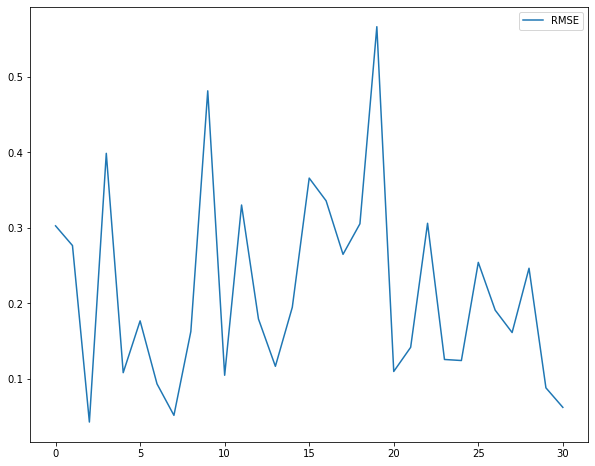

In [25]:
pd.DataFrame(RMSE, columns=['RMSE']).plot(figsize = (10, 8));

In [35]:
print(f'Average RMSE of PJM Dataset : {np.average(RMSE_PJM)}')

Average RMSE of PJM Dataset : 0.21528055542433777


In [165]:
std_dv = combined_df.drop(['h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10',
       'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20',
       'h21', 'h22', 'h23', 'h0_m', 'h1_m', 'h2_m',
       'h3_m', 'h4_m', 'h5_m', 'h6_m',
       'h7_m', 'h8_m', 'h9_m', 'h10_m',
       'h11_m', 'h12_m', 'h13_m', 'h14_m',
        'h15_m', 'h16_m', 'h17_m',
       'h18_m', 'h19_m', 'h20_m', 'h21_m',
         'h22_m', 'h23_m', 'abs_err_0',
       'abs_err_1', 'abs_err_2', 'abs_err_3', 'abs_err_4', 'abs_err_5',
       'abs_err_6', 'abs_err_7', 'abs_err_8', 'abs_err_9', 'abs_err_10',
       'abs_err_11', 'abs_err_12', 'abs_err_13', 'abs_err_14', 'abs_err_15',
       'abs_err_16', 'abs_err_17', 'abs_err_18', 'abs_err_19', 'abs_err_20',
       'abs_err_21', 'abs_err_22', 'abs_err_23'], axis=1)

sharpness_score = []
for i in range(0, len(std_dv)):
    sharpness_score.append(std_dv.iloc[i].sum()/24)

sharpness_score = pd.DataFrame(sharpness_score, columns=['Sharpness Score'], index=std_dv.index)

sharpness_score.reset_index(inplace=True)

sharpness_score['Day'] = sharpness_score['Date'].dt.day_name()

sharpness_score['RMSE'] = RMSE_PJM

avg_shaprness = sharpness_score.groupby('Day').mean()

avg_shaprness

,Sharpness Score,RMSE
Day,,
Friday,7.746192,0.284519
Monday,7.446509,0.182714
Saturday,5.063388,0.225623
Sunday,7.366110,0.319092
Thursday,11.446203,0.130283
Tuesday,9.045150,0.199045
Wednesday,7.386486,0.196958


<AxesSubplot:xlabel='Day'>

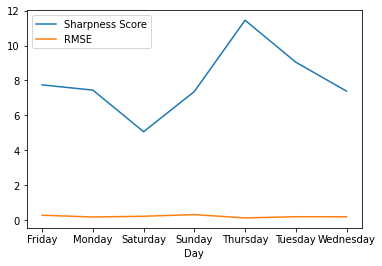

In [166]:
avg_shaprness.plot()

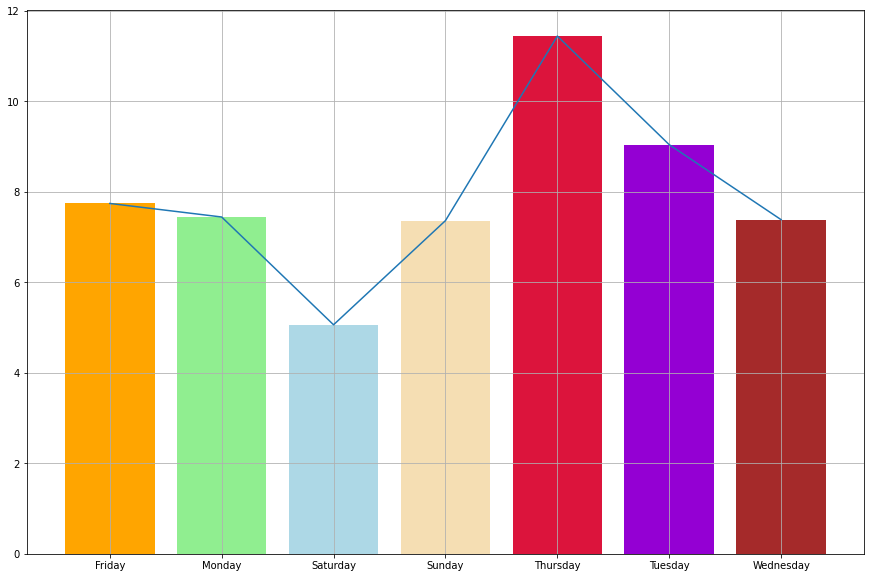

In [167]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.bar(avg_shaprness.index, height=avg_shaprness['Sharpness Score'], color=['Orange', 'LightGreen', 'LightBlue', 'Wheat', 'Crimson', 'DarkViolet', 'Brown'])
ax.plot(avg_shaprness.index, avg_shaprness['Sharpness Score'])
ax.grid()

In [28]:
RMSE_PJM .to_csv('PJMRMSE.csv')

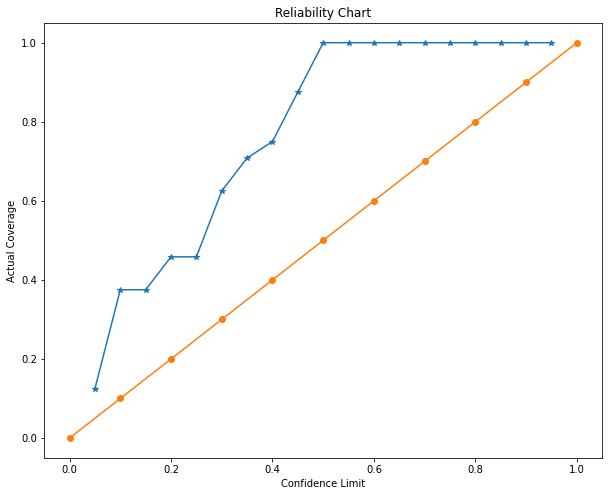

In [29]:
x = []
y = []
for sample in date_coverages[0]:
    x.append(sample[0])
    y.append(sample[1])
    
fig, ax = plt.subplots(figsize = (10, 8))
ax.plot(x, y, '-*')
ax.plot(np.arange(0.0,1.1, 0.1), np.arange(0.0,1.1, 0.1), '-o')
ax.set(xlabel='Confidence Limit', ylabel='Actual Coverage', title='Reliability Chart');

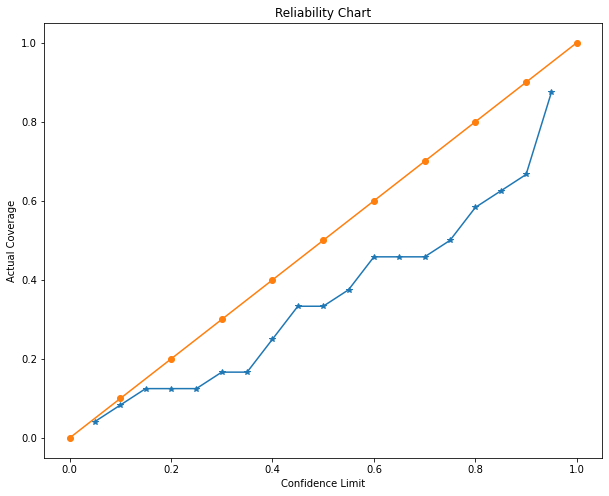

In [30]:
x = []
y = []
for sample in date_coverages[8]:
    x.append(sample[0])
    y.append(sample[1])
    
fig, ax = plt.subplots(figsize = (10, 8))
ax.plot(x, y, '*-')
ax.plot(np.arange(0.0,1.1, 0.1), np.arange(0.0,1.1, 0.1), '-o' )
ax.set(xlabel='Confidence Limit', ylabel='Actual Coverage', title='Reliability Chart');